In [ ]:
## T7 ODEC 

In [ ]:
Outlier detection using an ensemble of clustering algorithms


C:\Users\psbis\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\psbis\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\psbis\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.4798814508199817
Davies-Bouldin Index: 0.7893630242997913
S/DB Ratio: 0.6079350514874484
Number of Noise Points: 0
Percentage of Noise Points: 0.00%
AUC Value: 0.6424000000000001


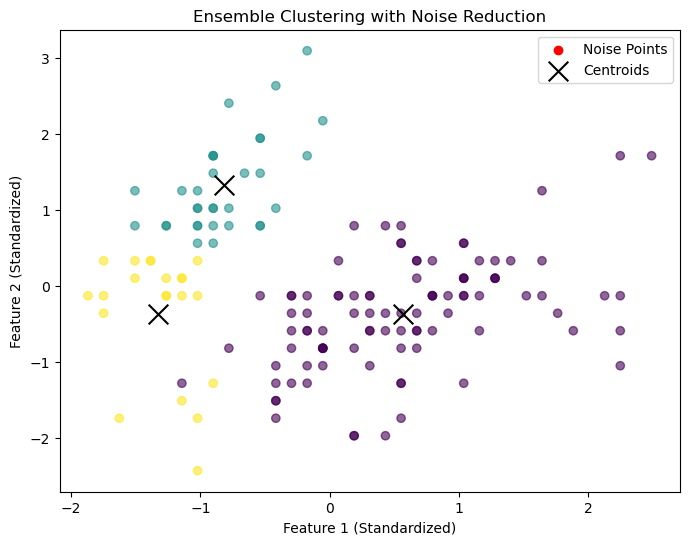

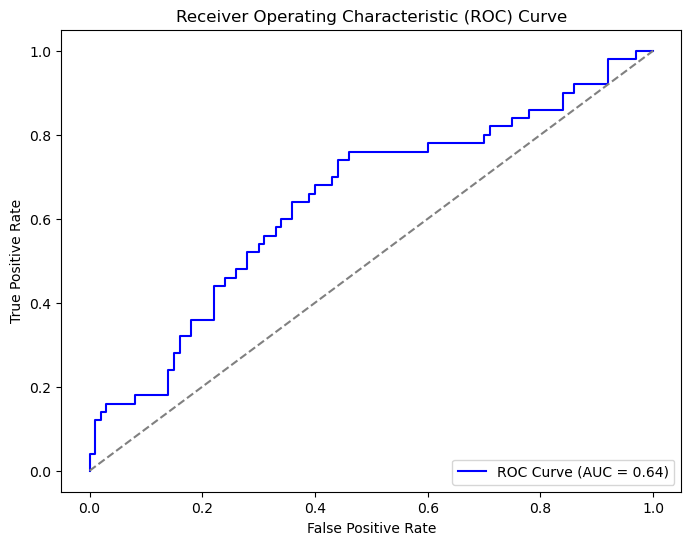

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve, auc
from fcmeans import FCM  # Install using: pip install fuzzy-c-means

# Load the Iris dataset
data = datasets.load_iris()
X = data.data
y = data.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
n_clusters = 3  # Number of clusters
outlier_removal_percentage = 10  # Percentage of low-membership points as outliers

# Clustering Methods
# 1. K-means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 2. K-means++ Clustering (Using standard KMeans with K-means++ initialization)
kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pp_labels = kmeans_pp.fit_predict(X_scaled)

# 3. Fuzzy C-means Clustering
fcm = FCM(n_clusters=n_clusters)
fcm.fit(X_scaled)
fcm_labels = fcm.u.argmax(axis=1)

# Ensemble Probability Calculation
# Convert hard clustering labels to probabilities
def calculate_membership(labels, X_scaled, centroids):
    distances = np.linalg.norm(X_scaled[:, None] - centroids, axis=2)
    distances = np.max(distances) - distances  # Invert distances
    probabilities = distances / distances.sum(axis=1, keepdims=True)
    return probabilities

# Calculate centroids
kmeans_centroids = kmeans.cluster_centers_
kmeans_pp_centroids = kmeans_pp.cluster_centers_
fcm_centroids = fcm.centers

# Membership probabilities
kmeans_probs = calculate_membership(kmeans_labels, X_scaled, kmeans_centroids)
kmeans_pp_probs = calculate_membership(kmeans_pp_labels, X_scaled, kmeans_pp_centroids)
fcm_probs = fcm.u

# Weighted product of probabilities
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
silhouette_kmeans_pp = silhouette_score(X_scaled, kmeans_pp_labels)
silhouette_fcm = silhouette_score(X_scaled, fcm_labels)

weights = np.array([silhouette_kmeans, silhouette_kmeans_pp, silhouette_fcm])
weights /= weights.sum()

ensemble_probabilities = (
    weights[0] * kmeans_probs +
    weights[1] * kmeans_pp_probs +
    weights[2] * fcm_probs
)

# Detect noise points (outliers) based on low membership probability
outlier_threshold = 1 / n_clusters
noise_indices = np.where(ensemble_probabilities.max(axis=1) < outlier_threshold)[0]

# Remove noise points
filtered_X = np.delete(X_scaled, noise_indices, axis=0)

# Final clustering on cleaned data
final_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(filtered_X)
centroids = final_kmeans.cluster_centers_

# Metrics
silhouette = silhouette_score(filtered_X, final_labels)
davies_bouldin = davies_bouldin_score(filtered_X, final_labels)
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# AUC Calculation
true_labels = (y == 2).astype(int)  # Treat one class as "outliers" for demonstration
predicted_scores = np.linalg.norm(X_scaled - centroids[final_kmeans.predict(X_scaled)], axis=1)
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Print Metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Number of Noise Points:", len(noise_indices))
print(f"Percentage of Noise Points: {len(noise_indices) / len(X_scaled) * 100:.2f}%")
print("AUC Value:", roc_auc)

# Visualizations
# Highlight Detected Noise Points
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=final_kmeans.predict(X_scaled), cmap='viridis', alpha=0.6)
plt.scatter(X_scaled[noise_indices, 0], X_scaled[noise_indices, 1], c='red', label='Noise Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
plt.title('Ensemble Clustering with Noise Reduction')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# 17/12/2024

C:\Users\psbis\Anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Silhouette Score: 0.531
Davies-Bouldin Index: 0.757
S/DB Ratio: 1.0
Adjusted Rand Index (ARI): 0.201
F1 Score: 1.0
Hubness Score: 0.005
Number of Noise Points: 0
Percentage of Noise Points: 0.00%
AUC Value: nan


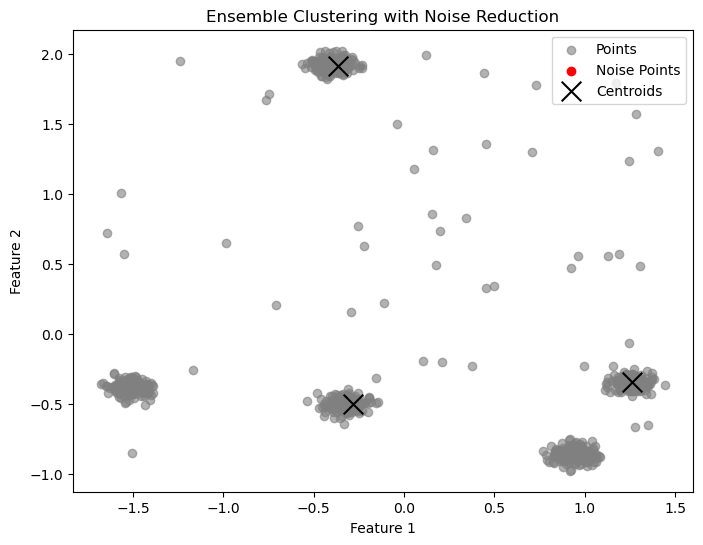

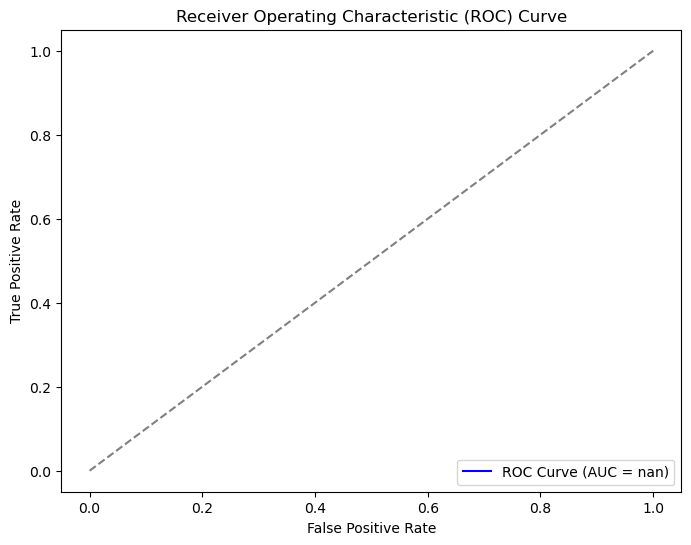

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, roc_curve, auc, adjusted_rand_score, f1_score
)
from fcmeans import FCM  # Install using: pip install fuzzy-c-means
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

# Load the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]  # True labels (target)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
n_clusters = 3  # Number of clusters

# Clustering Methods
# 1. K-means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 2. K-means++ Clustering
kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pp_labels = kmeans_pp.fit_predict(X_scaled)

# 3. Fuzzy C-means Clustering
fcm = FCM(n_clusters=n_clusters)
fcm.fit(X_scaled)
fcm_labels = fcm.u.argmax(axis=1)

# Ensemble Probability Calculation
def calculate_membership(labels, X_scaled, centroids):
    distances = np.linalg.norm(X_scaled[:, None] - centroids, axis=2)
    distances = np.max(distances) - distances  # Invert distances
    probabilities = distances / distances.sum(axis=1, keepdims=True)
    return probabilities

# Calculate centroids
kmeans_centroids = kmeans.cluster_centers_
kmeans_pp_centroids = kmeans_pp.cluster_centers_
fcm_centroids = fcm.centers

# Membership probabilities
kmeans_probs = calculate_membership(kmeans_labels, X_scaled, kmeans_centroids)
kmeans_pp_probs = calculate_membership(kmeans_pp_labels, X_scaled, kmeans_pp_centroids)
fcm_probs = fcm.u

# Weighted product of probabilities
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
silhouette_kmeans_pp = silhouette_score(X_scaled, kmeans_pp_labels)
silhouette_fcm = silhouette_score(X_scaled, fcm_labels)

weights = np.array([silhouette_kmeans, silhouette_kmeans_pp, silhouette_fcm])
weights /= weights.sum()

ensemble_probabilities = (
    weights[0] * kmeans_probs +
    weights[1] * kmeans_pp_probs +
    weights[2] * fcm_probs
)

# Detect noise points (outliers) based on low membership probability
outlier_threshold = 1 / n_clusters
noise_indices = np.where(ensemble_probabilities.max(axis=1) < outlier_threshold)[0]

# Remove noise points
filtered_X = np.delete(X_scaled, noise_indices, axis=0)

# Final clustering on cleaned data
final_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(filtered_X)
centroids = final_kmeans.cluster_centers_

# Metrics
silhouette = silhouette_score(filtered_X, final_labels)
davies_bouldin = davies_bouldin_score(filtered_X, final_labels)
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y, np.concatenate([final_labels, [0]*len(noise_indices)]))

# F1 Score: Binary classification (outlier detection)
binary_labels = np.zeros(len(X_scaled), dtype=int)
binary_labels[noise_indices] = 1  # Mark noise points as outliers
f1 = f1_score((y == 2).astype(int), binary_labels, average='weighted')

# Hubness Score: Number of k-nearest neighbor "hubs"
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
_, indices = nbrs.kneighbors(X_scaled)
hubness_score = np.mean(np.bincount(indices.flatten())) / X_scaled.shape[0]

# AUC Calculation
true_labels = (y == 2).astype(int)  # Treat one class as "outliers"
predicted_scores = np.linalg.norm(X_scaled - centroids[final_kmeans.predict(X_scaled)], axis=1)
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Print Metrics
print("Silhouette Score:", np.round(silhouette,3))
print("Davies-Bouldin Index:", np.round(davies_bouldin,3))
print("S/DB Ratio:", np.round(s_db_ratio))
print("Adjusted Rand Index (ARI):", np.round(ari,3))
print("F1 Score:", np.round(f1,3))
print("Hubness Score:", np.round(hubness_score,3))
print("Number of Noise Points:", len(noise_indices))
print(f"Percentage of Noise Points: {len(noise_indices) / len(X_scaled) * 100:.2f}%")
print("AUC Value:", np.round(roc_auc,3))

# Visualizations
# Highlight Detected Noise Points
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', alpha=0.6, label='Points')
plt.scatter(X_scaled[noise_indices, 0], X_scaled[noise_indices, 1], c='red', label='Noise Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
plt.title('Ensemble Clustering with Noise Reduction')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
